In [1]:
import urllib
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "12_generation/12c_gan.ipynb"
_nb_title = "GANs"
_icons=["https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png", "https://www.tensorflow.org/images/colab_logo_32px.png", "https://www.tensorflow.org/images/GitHub-Mark-32px.png", "https://www.tensorflow.org/images/download_logo_32px.png"]
_links=["https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?" + urllib.parse.urlencode({"name": _nb_title, "download_url": "https://github.com/takumiohym/practical-ml-vision-book-ja/raw/master/"+_nb_loc}), "https://colab.research.google.com/github/takumiohym/practical-ml-vision-book-ja/blob/master/{0}".format(_nb_loc), "https://github.com/takumiohym/practical-ml-vision-book-ja/blob/master/{0}".format(_nb_loc), "https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/master/{0}".format(_nb_loc)]
md("""<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="{0}"><img src="{4}"/>Run in Vertex AI Workbench</a></td><td><a target="_blank" href="{1}"><img src="{5}" />Run in Google Colab</a></td><td><a target="_blank" href="{2}"><img src="{6}" />View source on GitHub</a></td><td><a href="{3}"><img src="{7}" />Download notebook</a></td></table><br/><br/>""".format(_links[0], _links[1], _links[2], _links[3], _icons[0], _icons[1], _icons[2], _icons[3]))

<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?name=GANs&download_url=https%3A%2F%2Fgithub.com%2Ftakumiohym%2Fpractical-ml-vision-book-ja%2Fraw%2Fmaster%2F12_generation%2F12c_gan.ipynb"><img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/>Run in Vertex AI Workbench</a></td><td><a target="_blank" href="https://colab.research.google.com/github/takumiohym/practical-ml-vision-book-ja/blob/master/12_generation/12c_gan.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a></td><td><a target="_blank" href="https://github.com/takumiohym/practical-ml-vision-book-ja/blob/master/12_generation/12c_gan.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td><td><a href="https://raw.githubusercontent.com/takumiohym/practical-ml-vision-book-ja/master/12_generation/12c_gan.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a></td></table><br/><br/>

# 敵対的生成ネットワーク(GAN)
MNISTを利用して、全結合層で構成されたシンプルなGANと、DCGANの学習を行います。

## 実行環境
このノートブックは、TPU上でもGPU上でも実行可能です。

Vertex AI WorkbenchやColabでGPUやTPUを使用する方法については[実行環境のセットアップ
](https://github.com/takumiohym/practical-ml-vision-book-ja/tree/main/environment_setup)を参照してください。

In [2]:
import os, shutil
import tensorflow as tf

try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs or multi-GPU machines
    strategy = tf.distribute.MirroredStrategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

2022-12-14 14:53:13.714338: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-14 14:53:13.714385: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-14 14:53:15.861874: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-14 14:53:15.861927: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-14 14:53:15.861953: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tpu-direct): /proc/driver/nvidia/version does not exist


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


2022-12-14 14:53:16.111335: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
2022-12-14 14:53:16.123840: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:272] Initialize GrpcChannelCache for job worker -> {0 -> 10.112.92.178:8470}
2022-12-14 14:53:16.123877: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:272] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:42635}
2022-12-14 14:53:16.143960: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:272] Initialize GrpcChannelCache for job worker -> {0 -> 10.112.92.178:8470}
2022-12-14 14:53:16.144002: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:272] Initial

INFO:tensorflow:Initializing the TPU system: tpu-direct


INFO:tensorflow:Initializing the TPU system: tpu-direct


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [3]:
# Import libraries and modules
import matplotlib.pyplot as plt
import numpy as np

## GAN

生成器と識別機の両方にDenseレイヤーのみを使用したシンプルなGANを作成します。

In [4]:
# Create the generator.
latent_dim = 512
with strategy.scope():
    vanilla_generator = tf.keras.Sequential(
        [
            tf.keras.Input(shape=(latent_dim,)),
            tf.keras.layers.Dense(units=256),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Dense(units=512),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Dense(units=1024),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Dense(units=28 * 28 * 1, activation="tanh"),
            tf.keras.layers.Reshape(target_shape=(28, 28, 1))
        ],
        name="vanilla_generator"
    )
vanilla_generator.summary()

Model: "vanilla_generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               131328    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 784)         

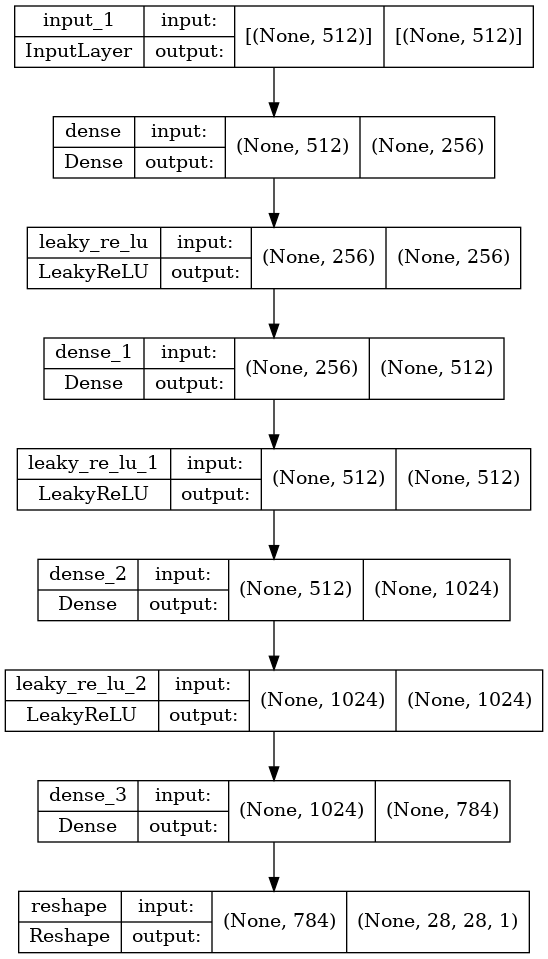

In [5]:
# Plot generator model.
tf.keras.utils.plot_model(
    model=vanilla_generator,
    to_file="vanilla_generator_model.png",
    show_shapes=True,
    show_layer_names=True
)

In [6]:
# Create the discriminator.
with strategy.scope():
    vanilla_discriminator = tf.keras.Sequential(
        [
            tf.keras.Input(shape=(28, 28, 1)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(units=1024),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Dense(units=512),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Dense(units=256),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Dense(units=1),
        ],
        name="vanilla_discriminator"
    )
vanilla_discriminator.summary()

Model: "vanilla_discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 1024)              803840    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               524800    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 256)     

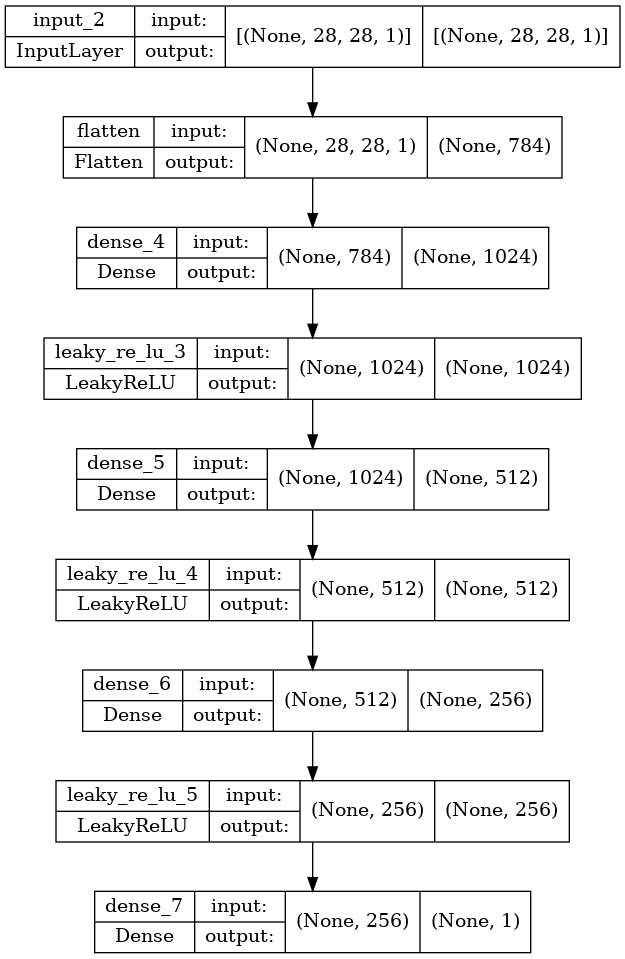

In [7]:
# Plot discriminator model.
tf.keras.utils.plot_model(
    model=vanilla_discriminator,
    to_file="vanilla_discriminator_model.png",
    show_shapes=True,
    show_layer_names=True
)

生成器と識別機ネットワークの学習をシンプルにするために`GAN`という名前のカスタム`Model`クラスを作成します。

In [8]:
class GAN(tf.keras.Model):
    """Custom model for training a GAN.

    Attributes:
        discriminator: Keras `Model`, the discriminator network.
        generator: Keras `Model`, the generator network.
        latent_dim: int, the latent vector dimension length.
        one_sided_label_smoothing: float, how much to smooth the real image
            labels by value in [0., 1.].
        discriminator_optimizer: Keras `Optimizer`, optimizer for
            discriminator network.
        generator_optimizer: Keras `Optimizer`, optimizer for generator
            network.
        loss_fn: Keras `Loss`, loss function for training both networks.
    """
    def __init__(
        self, discriminator, generator, latent_dim, one_sided_label_smoothing
    ):
        """Instantiates `GAN` model class.

        Args:
            discriminator: Keras `Model`, the discriminator network.
            generator: Keras `Model`, the generator network.
            latent_dim: int, the latent vector dimension length.
            one_sided_label_smoothing: float, how much to smooth the real image
                labels by value in [0., 1.].
        """
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.one_sided_label_smoothing = one_sided_label_smoothing

    def compile(self, discriminator_optimizer, generator_optimizer, loss_fn):
        """Overrides base `Model` class' compile method.

        Args:
            discriminator_optimizer: Keras `Optimizer`, optimizer for
                discriminator network.
            generator_optimizer: Keras `Optimizer`, optimizer for generator
                network.
            loss_fn: Keras `Loss`, loss function for training both networks.
        """
        super(GAN, self).compile()
        self.discriminator_optimizer = discriminator_optimizer
        self.generator_optimizer = generator_optimizer
        self.loss_fn = loss_fn

    def discriminator_train_step(self, batch_size, real_images):
        """Trains discriminator for one step.

        Args:
            batch_size: tensor, scalar tensor representing number of elements
                in the mini-batch.
            real_images: tensor, rank 4 tensor of real images with shape
                (batch_size, height, width, depth).

        Returns:
            discriminator_loss: tensor, scalar loss of disriminator step.
        """
        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # Generate images from noise.
        generated_images = self.generator(inputs=random_latent_vectors)

        # Combine generated images with real images.
        combined_images = tf.concat(
            values=[generated_images, real_images], axis=0
        )

        # Create fake and real labels.
        fake_labels = tf.zeros(shape=(batch_size, 1))
        real_labels = tf.ones(shape=(batch_size, 1))

        # Smooth real labels to help with training.
        real_labels *= self.one_sided_label_smoothing

        # Combine labels to be in-line with combined images.
        labels = tf.concat(
            values=[fake_labels, real_labels], axis=0
        )

        # Train ONLY the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(inputs=combined_images)
            discriminator_loss = self.loss_fn(
                y_true=labels, y_pred=predictions
            )

        grads = tape.gradient(
            target=discriminator_loss,
            sources=self.discriminator.trainable_weights
        )

        self.discriminator_optimizer.apply_gradients(
            grads_and_vars=zip(grads, self.discriminator.trainable_weights)
        )

        return discriminator_loss

    def generator_train_step(self, batch_size):
        """Trains generator for one step.

        Args:
            batch_size: tensor, scalar tensor representing number of elements
                in the mini-batch.

        Returns:
            generator_loss: tensor, scalar loss of generator step.
        """
        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # Create labels as if they're real images.
        labels = tf.ones(shape=(batch_size, 1))

        # Train ONLY the generator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(
                inputs=self.generator(inputs=random_latent_vectors)
            )
            generator_loss = self.loss_fn(y_true=labels, y_pred=predictions)

        grads = tape.gradient(
            target=generator_loss, sources=self.generator.trainable_weights
        )

        self.generator_optimizer.apply_gradients(
            grads_and_vars=zip(grads, self.generator.trainable_weights)
        )

        return generator_loss

    def train_step(self, real_images):
        """Trains `GAN` for one step.

        Args:
            real_images: tensor, rank 4 tensor of real images with shape
                (batch_size, height, width, depth).

        Returns:
            losses: dict, dictionary of losses from each sub-training step.
        """
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Get dynamic batch size to use for random noise vectors.
        batch_size = tf.shape(input=real_images)[0]

        # First train discriminator.
        discriminator_loss = tf.reduce_sum(self.discriminator_train_step(
            batch_size, real_images
        )) * tf.cast((1 / batch_size), tf.float32)

        # Then train generator.
        generator_loss = tf.reduce_sum(self.generator_train_step(
            batch_size
        )) * tf.cast((1 / batch_size), tf.float32)
        
        losses = {
            "discriminator_loss": discriminator_loss,
            "generator_loss": generator_loss
        }

        return losses


In [9]:
def create_train_dataset(batch_size):
    """Creates training dataset.

    Args:
        batch_size: int, number of elements in a mini-batch.

    Returns:
        dataset: `Dataset`, dataset object for training using MNIST.
    """
    # Get and format MNIST data.
    (x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

    # Let's combine both training and test sets.
    combined = np.concatenate([x_train, x_test])
    combined = (combined.astype("float32") - 127.5) / 255.0
    combined = np.reshape(combined, newshape=(-1, 28, 28, 1))

    # Create tf.data.Dataset for training.
    dataset = tf.data.Dataset.from_tensor_slices(tensors=combined)
    dataset = dataset.shuffle(buffer_size=70000).batch(batch_size=batch_size, drop_remainder=True)

    return dataset


In [10]:
# Instantiate a GAN instance using our vanilla generator and discriminator.

with strategy.scope():
    vanilla_gan = GAN(
        discriminator=vanilla_discriminator,
        generator=vanilla_generator,
        latent_dim=latent_dim,
        one_sided_label_smoothing=0.9
    )

vanilla_gan.compile(
    discriminator_optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0002, beta_1=0.5, beta_2=0.999, epsilon=1e-8
    ),
    generator_optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0002, beta_1=0.5, beta_2=0.999, epsilon=1e-8
    ),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
)

# Train vanilla GAN model.
vanilla_gan_history = vanilla_gan.fit(
    create_train_dataset(batch_size=128 * strategy.num_replicas_in_sync), epochs=30
)

Epoch 1/30
68/68 [==============================] - 7s 12ms/step - discriminator_loss: 1.2233 - generator_loss: 1.4575
Epoch 2/30
68/68 [==============================] - 1s 13ms/step - discriminator_loss: 1.4482 - generator_loss: 1.2204
Epoch 3/30
68/68 [==============================] - 1s 13ms/step - discriminator_loss: 1.3036 - generator_loss: 1.1525
Epoch 4/30
68/68 [==============================] - 1s 13ms/step - discriminator_loss: 1.1974 - generator_loss: 1.2853
Epoch 5/30
68/68 [==============================] - 1s 13ms/step - discriminator_loss: 1.3041 - generator_loss: 1.2639
Epoch 6/30
68/68 [==============================] - 1s 13ms/step - discriminator_loss: 1.1824 - generator_loss: 1.3861
Epoch 7/30
68/68 [==============================] - 1s 13ms/step - discriminator_loss: 1.2518 - generator_loss: 1.3938
Epoch 8/30
68/68 [==============================] - 1s 13ms/step - discriminator_loss: 1.2275 - generator_loss: 1.3803
Epoch 9/30
68/68 [==============================

損失の履歴を確認した後、学習済み済みモデルを使用して生成された画像をプロットしてみましょう。

In [11]:
def plot_loss_history(history):
    """Plots loss history.

    Args:
        history: `keras.callbacks.History`, history object from training job.
    """
    plt.plot(history.history["generator_loss"])
    plt.plot(history.history["discriminator_loss"])
    plt.title("Training losses")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["generator", "discriminator"], loc="upper left")
    plt.show()


In [12]:
def plot_images(images):
    """Plots images.

    Args:
        images: np.array, array of images of
            [num_images, image_size, image_size, num_channels].
    """
    num_images = len(images)

    plt.figure(figsize=(20, 20))
    for i in range(num_images):
        image = images[i]
        plt.subplot(1, num_images, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(
            tf.reshape(image, image.shape[:-1]),
            cmap="gray_r"
        )
    plt.show()

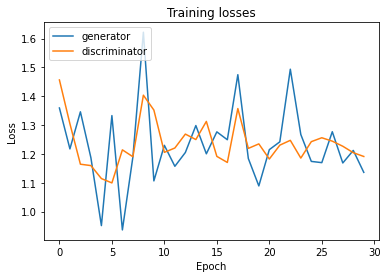

In [13]:
plot_loss_history(history=vanilla_gan_history)

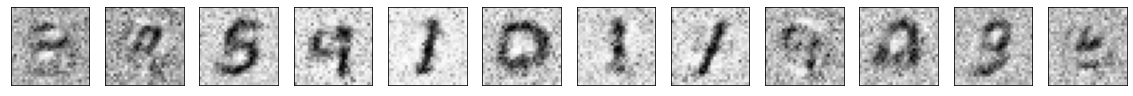

In [14]:
plot_images(
    images=vanilla_gan.generator(
        inputs=tf.random.normal(shape=(12, latent_dim))
    )
)

## DCGAN

Deep Convolutional GAN(DCGAN)は、識別機と生成器にそれぞれ `Dense`レイヤーの代わりに畳み込み(`Conv2D`)とデコンボリューション( `Conv2DTranspose`)を使用します。

In [15]:
# Create the generator
def create_generator_block(filters, kernel_size, strides, padding, alpha):
    """Creates generator block of layers.

    Args:
        filters: int, number of output filters/channels.
        kernel_size: int/2-tuple of ints, the height and width of the kernel.
        strides: int/2-tuple of ints, the height and width of each stride of
            sliding window.
        padding: str, the type of padding of the output: same or valid.
        alpha: float, the amount of leakiness of LeakyRelu activations.

    Returns:
        List of layers.
    """
    return [
        tf.keras.layers.Conv2DTranspose(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(alpha=alpha)
    ]

def create_dcgan_generator(latent_dim):
    """Creates deep convolutional GAN generator network.

    Args:
        latent_dim: int, the latent vector dimension length.

    Returns:
        Keras Sequential Model.
    """
    dcgan_generator = [
        tf.keras.Input(shape=(latent_dim,)),
        tf.keras.layers.Dense(units=7 * 7 * 256),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Reshape(target_shape=(7, 7, 256)),
    ] + create_generator_block(
        filters=128, kernel_size=4, strides=2, padding="same", alpha=0.2
    ) + create_generator_block(
        filters=128, kernel_size=4, strides=2, padding="same", alpha=0.2
    ) + [
        tf.keras.layers.Conv2DTranspose(
            filters=1,
            kernel_size=3,
            strides=1,
            padding="same",
            activation="tanh"
        )
    ]

    return tf.keras.Sequential(layers=dcgan_generator, name="dcgan_generator")

with strategy.scope():
    dcgan_generator = create_dcgan_generator(latent_dim=512)
dcgan_generator.summary()

Model: "dcgan_generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 12544)             6435072   
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 12544)             0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      524416    
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 128)      512       
 ormalization)                                                   
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 14, 14, 128)   

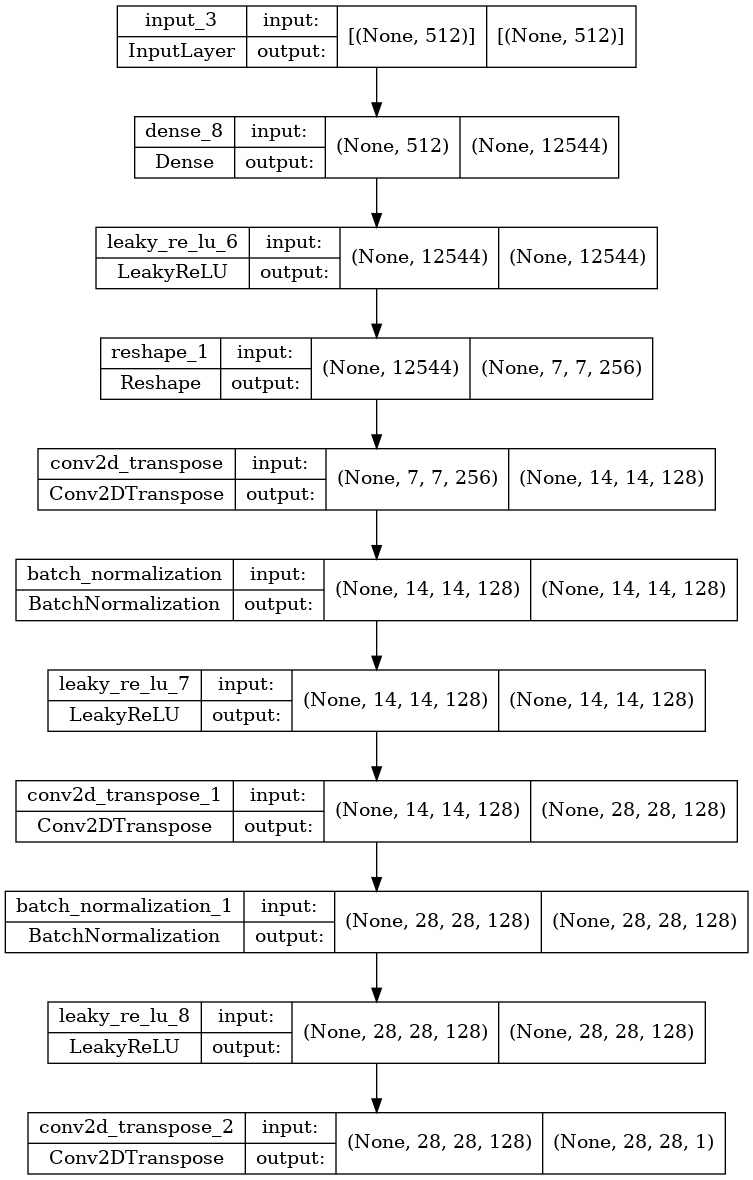

In [16]:
# Plot generator model.
tf.keras.utils.plot_model(
    model=dcgan_generator,
    to_file="dcgan_generator_model.png",
    show_shapes=True,
    show_layer_names=True
)

In [17]:
# Create the discriminator
def create_discriminator_block(filters, kernel_size, strides, padding, alpha):
    """Creates discriminator block of layers.

    Args:
        filters: int, number of output filters/channels.
        kernel_size: int/2-tuple of ints, the height and width of the kernel.
        strides: int/2-tuple of ints, the height and width of each stride of
            sliding window.
        padding: str, the type of padding of the output: same or valid.
        alpha: float, the amount of leakiness of LeakyRelu activations.

    Returns:
        List of layers.
    """
    return [
        tf.keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(alpha=alpha)
    ]

def create_dcgan_discriminator(input_shape):
    """Creates deep convolutional GAN discriminator network.

    Args:
        input_shape: tuple, the shape of the input without batch dimension.

    Returns:
        Keras Sequential Model.
    """
    dcgan_discriminator = [
        tf.keras.Input(shape=input_shape),
        tf.keras.layers.Conv2D(
            filters=64, kernel_size=3, strides=1, padding="same"
        ),
        tf.keras.layers.LeakyReLU(alpha=0.2)
    ] + create_discriminator_block(
        filters=128, kernel_size=3, strides=2, padding="same", alpha=0.2
    ) + create_discriminator_block(
        filters=128, kernel_size=3, strides=2, padding="same", alpha=0.2
    ) + create_discriminator_block(
        filters=256, kernel_size=3, strides=2, padding="same", alpha=0.2
    ) + [
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=1)
    ]

    return tf.keras.Sequential(layers=dcgan_discriminator, name="dcgan_discriminator")

with strategy.scope():
    dcgan_discriminator = create_dcgan_discriminator(input_shape=(28, 28, 1))
dcgan_discriminator.summary()

Model: "dcgan_discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 28, 28, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 batch_normalization_2 (Batc  (None, 14, 14, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         147584    
                                               

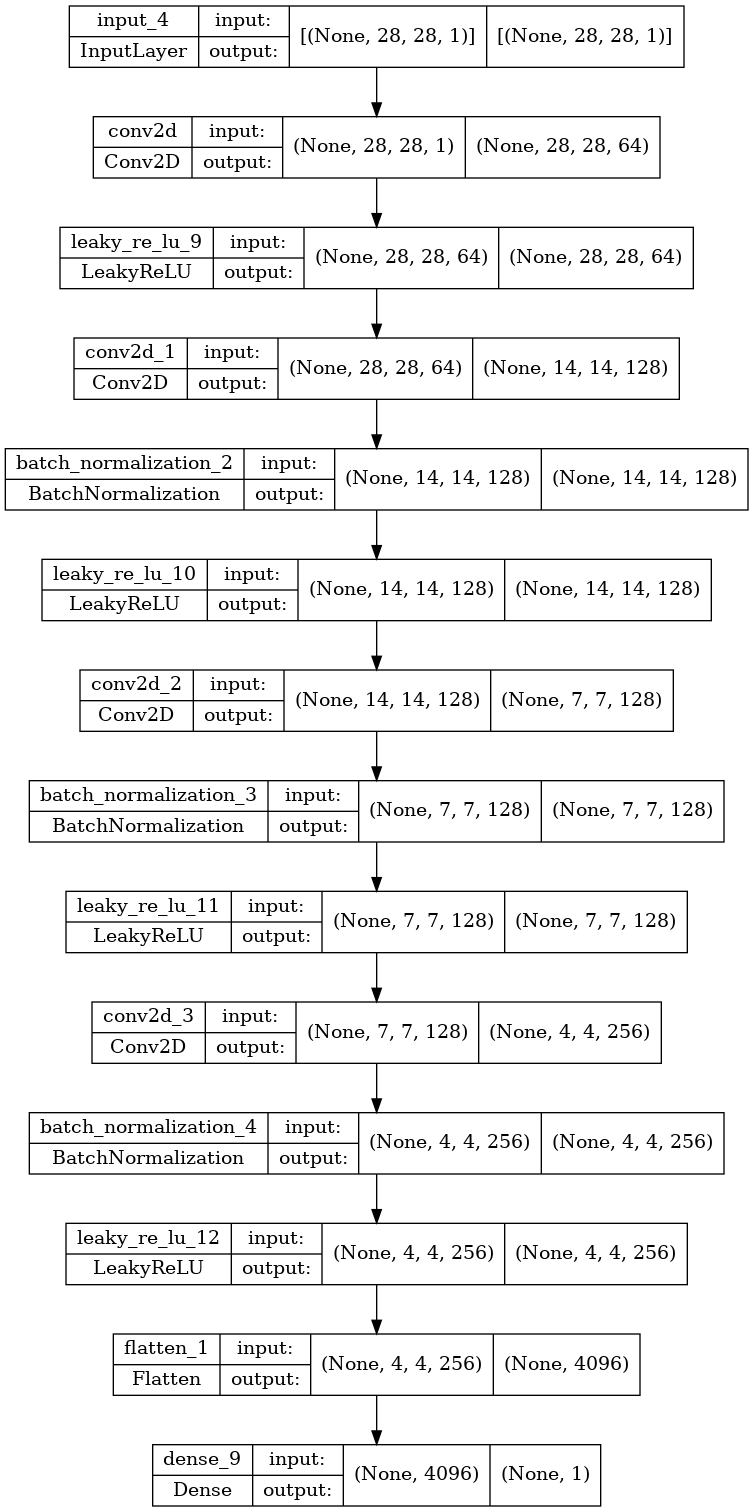

In [18]:
# Plot generator model.
tf.keras.utils.plot_model(
    model=dcgan_discriminator,
    to_file="dcgan_discriminator_model.png",
    show_shapes=True,
    show_layer_names=True
)

In [19]:
# Instantiate a GAN instance using our DCGAN generator and discriminator.
with strategy.scope():
    dcgan = GAN(
    discriminator=dcgan_discriminator,
    generator=dcgan_generator,
    latent_dim=latent_dim,
    one_sided_label_smoothing=0.9
    )

dcgan.compile(
    discriminator_optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0002, beta_1=0.5, beta_2=0.999, epsilon=1e-8
    ),
    generator_optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0002, beta_1=0.5, beta_2=0.999, epsilon=1e-8
    ),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
)

# Train DCGAN model.
dcgan_history = dcgan.fit(create_train_dataset(batch_size=128 * strategy.num_replicas_in_sync), epochs=50)

Epoch 1/50
68/68 [==============================] - 16s 21ms/step - discriminator_loss: 1.1019 - generator_loss: 1.4728
Epoch 2/50
68/68 [==============================] - 1s 21ms/step - discriminator_loss: 0.7759 - generator_loss: 2.6995
Epoch 3/50
68/68 [==============================] - 1s 21ms/step - discriminator_loss: 1.1407 - generator_loss: 1.0700
Epoch 4/50
68/68 [==============================] - 2s 21ms/step - discriminator_loss: 1.1575 - generator_loss: 0.9938
Epoch 5/50
68/68 [==============================] - 1s 21ms/step - discriminator_loss: 1.0848 - generator_loss: 1.1106
Epoch 6/50
68/68 [==============================] - 2s 21ms/step - discriminator_loss: 1.0380 - generator_loss: 1.1852
Epoch 7/50
68/68 [==============================] - 1s 21ms/step - discriminator_loss: 0.9851 - generator_loss: 1.2732
Epoch 8/50
68/68 [==============================] - 1s 21ms/step - discriminator_loss: 0.9172 - generator_loss: 1.2756
Epoch 9/50
68/68 [=============================

同様に、結果のプロットをしてみましょう。

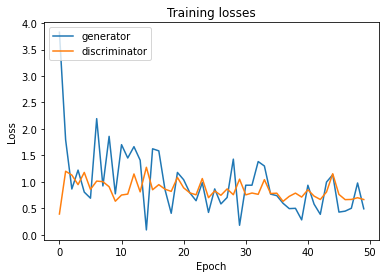

In [21]:
plot_loss_history(history=dcgan_history)

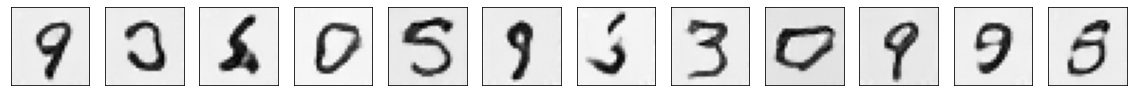

In [22]:
plot_images(
    images=dcgan.generator(inputs=tf.random.normal(shape=(12, latent_dim)))
)

## License
Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.